# Creditworthiness Prediction Using Random Forest

## Introduction
This notebook performs exploratory data analysis (EDA), preprocessing, and trains a random forest model to predict creditworthiness using the Statlog (German Credit Data) dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data). The dataset contains 1000 instances with 20 attributes (7 numerical, 13 categorical) and a binary target variable (1 for good credit, 2 for bad credit). A cost matrix prioritizes minimizing misclassifications of bad credits as good (cost=5) over good as bad (cost=1). The notebook includes detailed EDA, outlier handling, feature selection, model training, and exports the model for use in a Streamlit app.

## Data Loading
Load the dataset and assign column names based on the attribute description.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supressing all unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Define column names
columns = [
    'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_status', 'employment', 'installment_rate', 'personal_status',
    'other_parties', 'residence_since', 'property_magnitude', 'age',
    'other_payment_plans', 'housing', 'existing_credits', 'job',
    'num_dependents', 'own_telephone', 'foreign_worker', 'class'
]

# Load the dataset
df = pd.read_csv('data/german.data', delimiter=' ', header=None, names=columns)

# Display first few rows
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_rate,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


The dataset is loaded with 21 columns (20 features + 1 target). Categorical variables are encoded (e.g., 'A11' for checking_status), and numerical variables are in their raw form. The target variable 'class' is encoded as 1 (good) and 2 (bad).

## Initial Inspection
Check data types and missing values to understand the dataset's structure.

In [2]:
# Data types
df.dtypes

# Check for missing values
df.isnull().sum()

checking_status        0
duration               0
credit_history         0
purpose                0
credit_amount          0
savings_status         0
employment             0
installment_rate       0
personal_status        0
other_parties          0
residence_since        0
property_magnitude     0
age                    0
other_payment_plans    0
housing                0
existing_credits       0
job                    0
num_dependents         0
own_telephone          0
foreign_worker         0
class                  0
dtype: int64

All columns have appropriate data types (object for categorical, int64 for numerical). No missing values are present, confirming the dataset's completeness.

## Summary Statistics
Examine summary statistics for numerical variables to assess their distributions.

In [3]:
numerical_cols = ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']
df[numerical_cols].describe()

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


`credit_amount` ranges from 250 to 18424 DM (mean: 3271, std: 2822), indicating significant skewness. `duration` ranges from 4 to 72 months. `installment_rate` and `num_dependents` show discrete values, suggesting limited variability.

## Univariate Analysis - Numerical Variables
Visualize distributions using histograms, boxplots, and violin plots to understand spread and outliers.

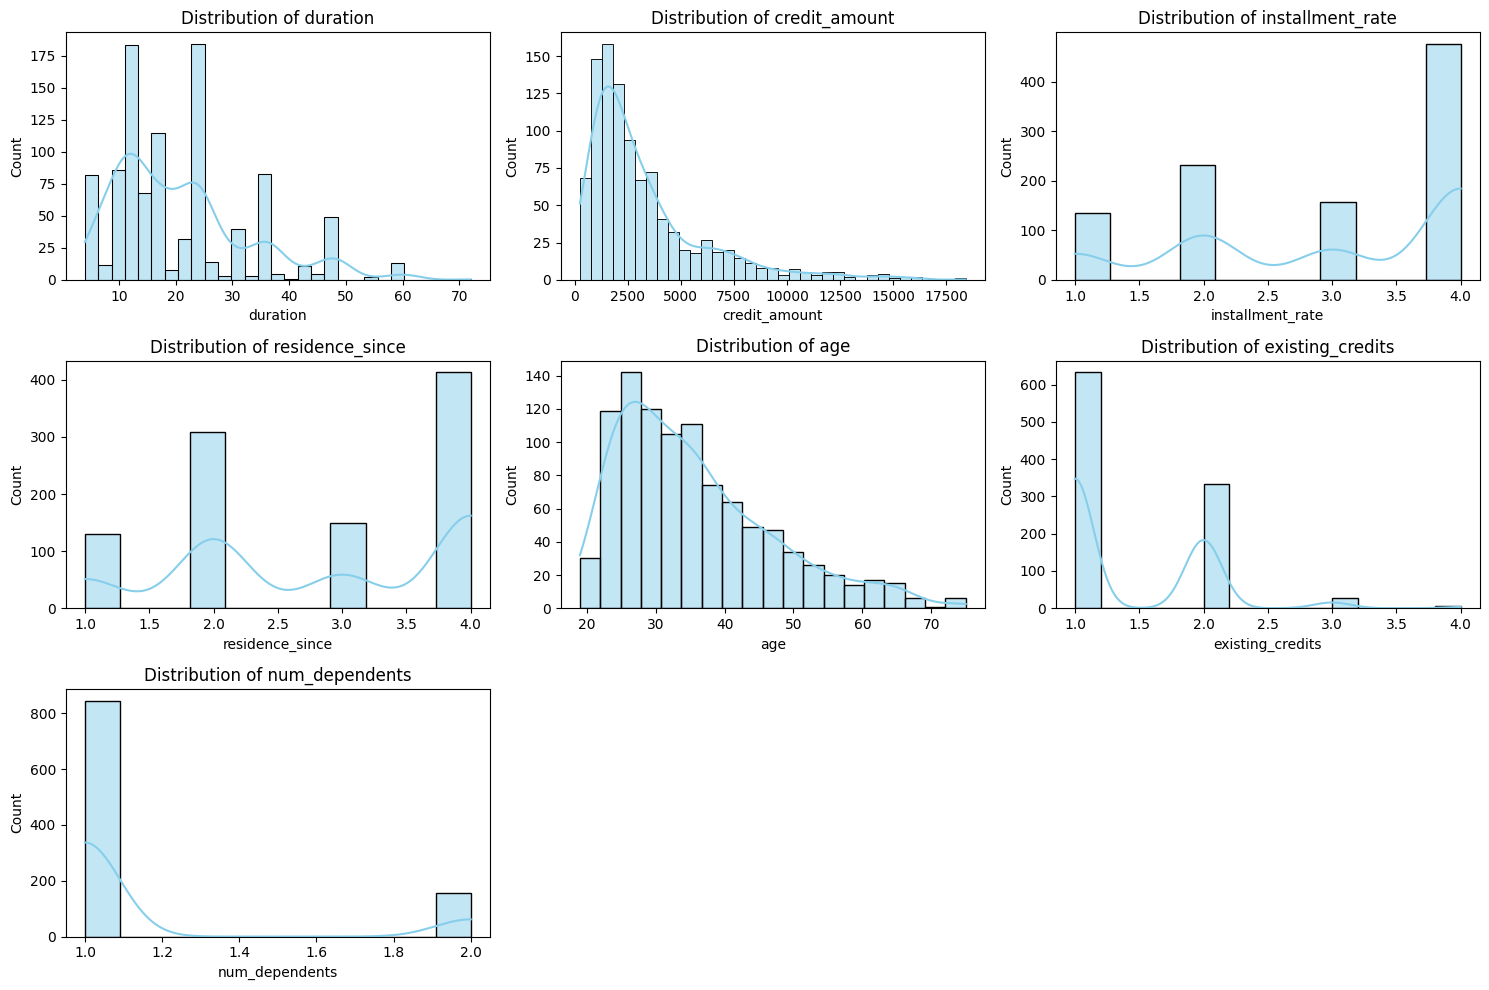

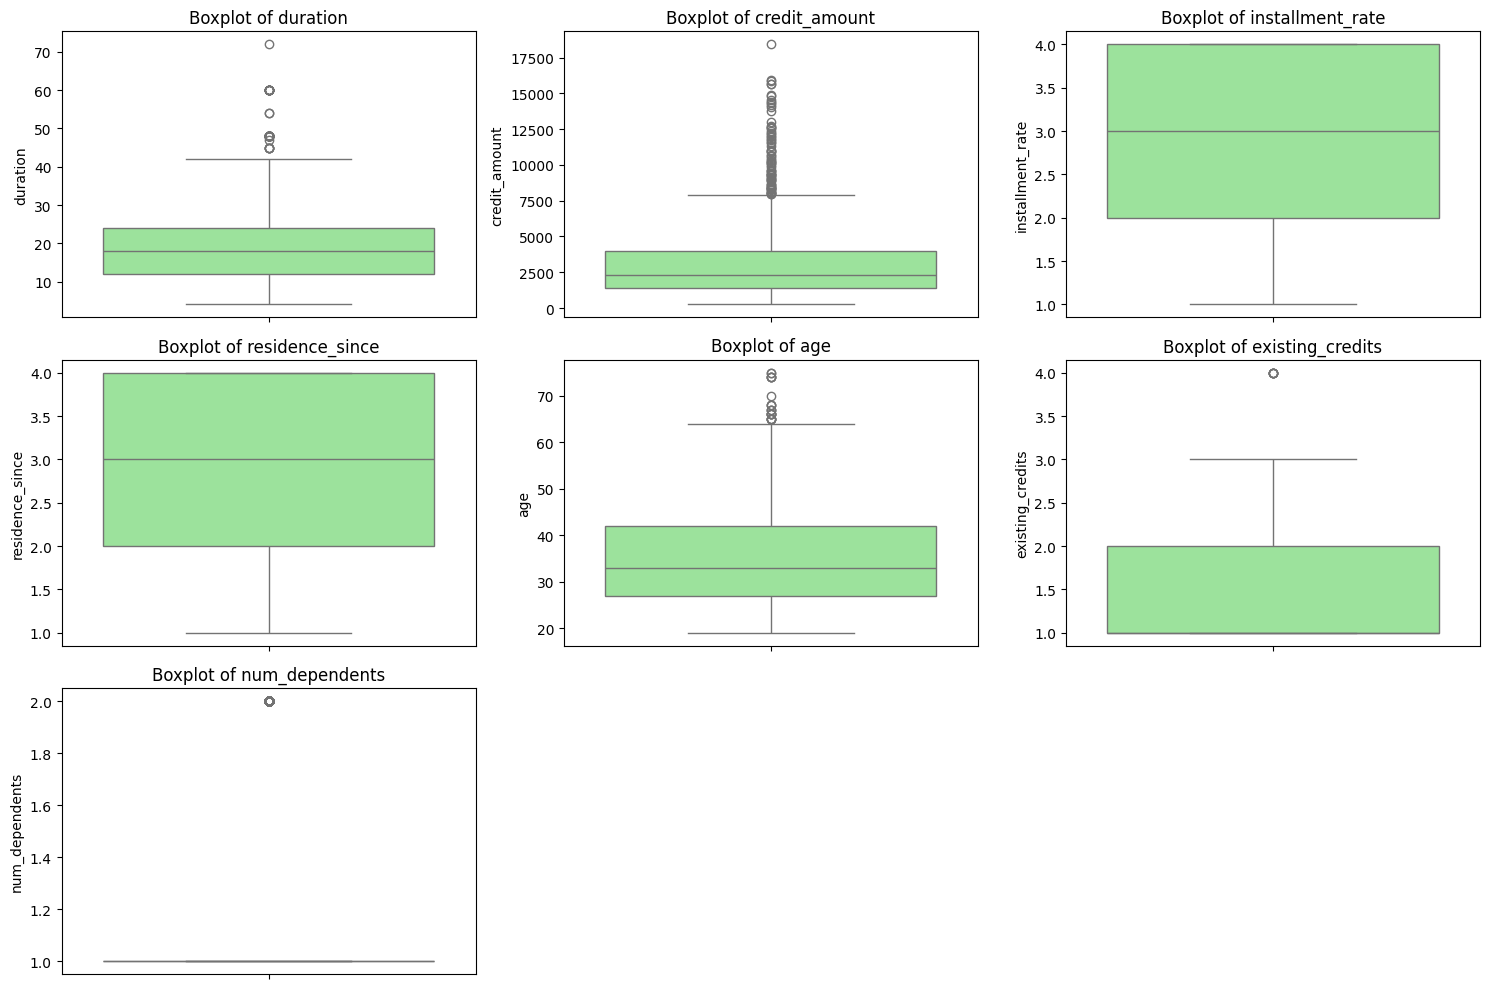

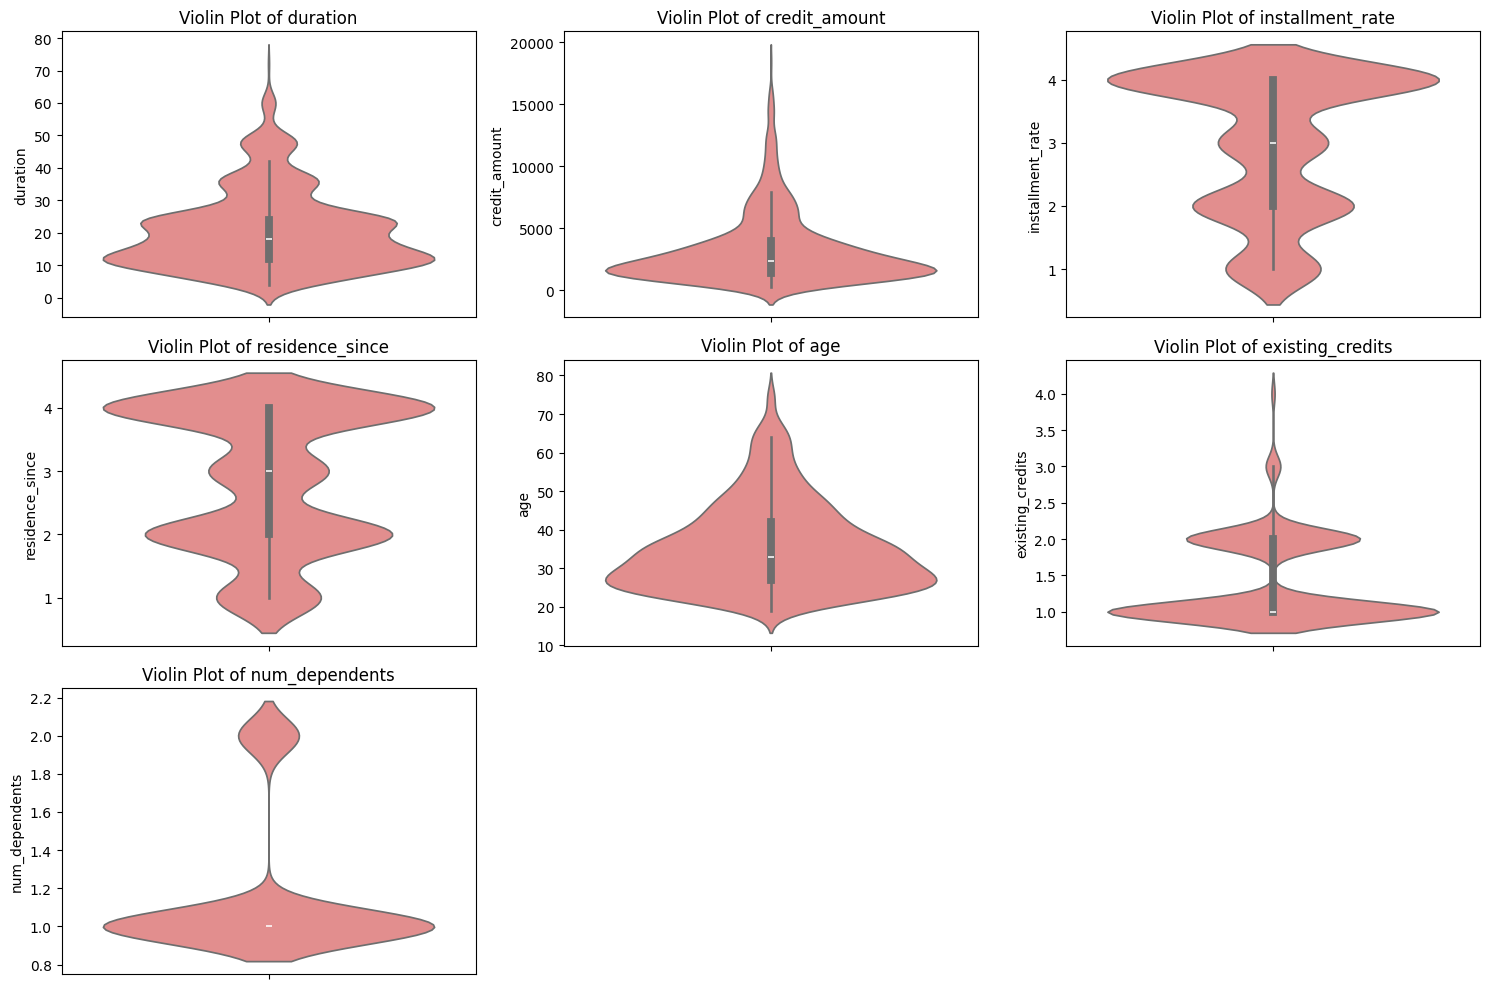

In [4]:
# Histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Violin plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(y=df[col], color='lightcoral')
    plt.title(f'Violin Plot of {col}')
plt.tight_layout()
plt.show()

Histograms confirm that `credit_amount` and `duration` are right-skewed, with long tails indicating outliers. Boxplots highlight outliers in `credit_amount`, `duration`, and `age`. Violin plots show similar distributions but emphasize density, revealing that `installment_rate` and `num_dependents` have concentrated values.

## Univariate Analysis - Categorical Variables
Examine frequency distributions using bar plots to understand category prevalence.

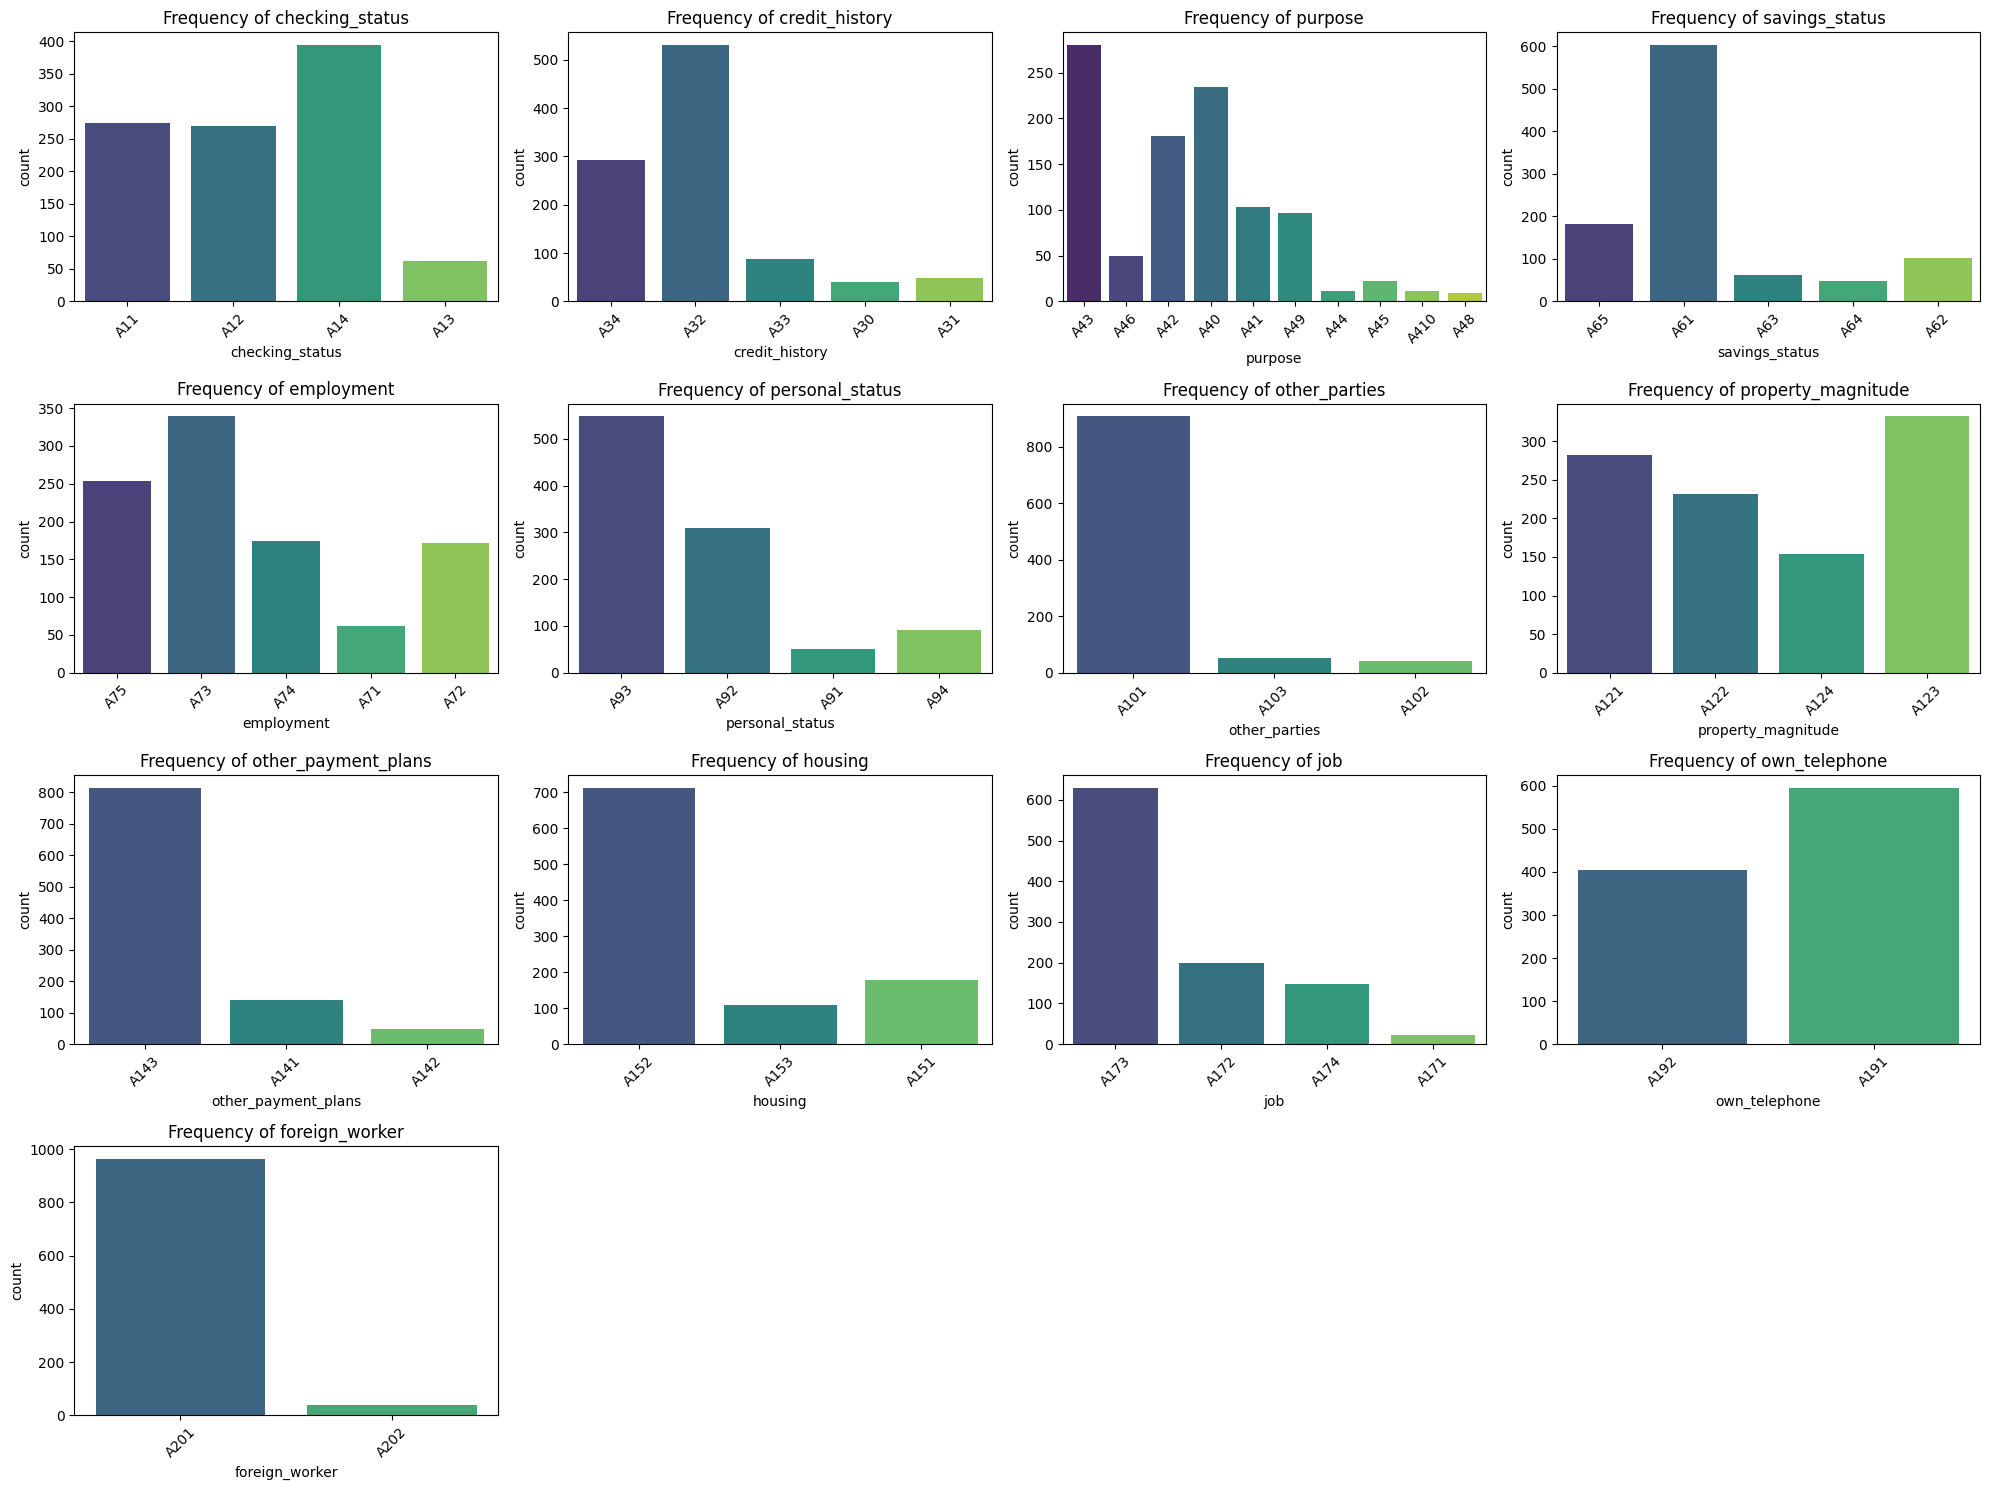

In [5]:
categorical_cols = [col for col in df.columns if col not in numerical_cols + ['class']]
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 4, i)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`checking_status` is dominated by 'A14' (no checking account, ~40% of instances). `purpose` shows high frequencies for 'A43' (radio/television) and 'A40' (new car). `own_telephone` and `foreign_worker` are nearly binary, with most instances being 'A191' (no telephone) and 'A201' (foreign worker: yes).

## Target Variable Distribution
Analyze the distribution of the target variable to assess class balance.

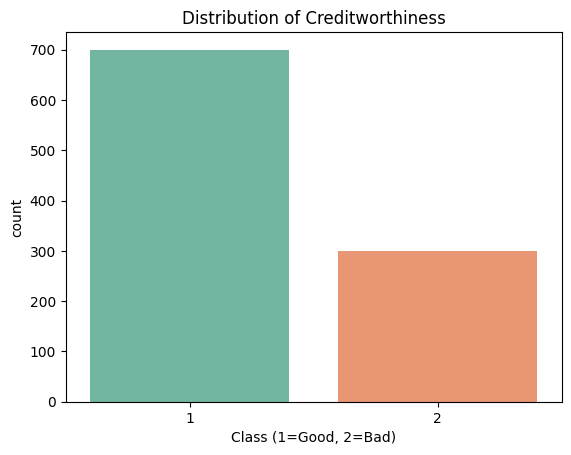

class
1    700
2    300
Name: count, dtype: int64

In [6]:
sns.countplot(x='class', data=df, palette='Set2')
plt.title('Distribution of Creditworthiness')
plt.xlabel('Class (1=Good, 2=Bad)')
plt.show()
df['class'].value_counts()

The target variable has 700 good credits (class 1) and 300 bad credits (class 2), indicating a 70:30 class imbalance. This imbalance, combined with the cost matrix, suggests a need to prioritize correctly identifying bad credits.

## Bivariate Analysis - Numerical vs. Target
Use boxplots and violin plots to explore relationships between numerical variables and the target.

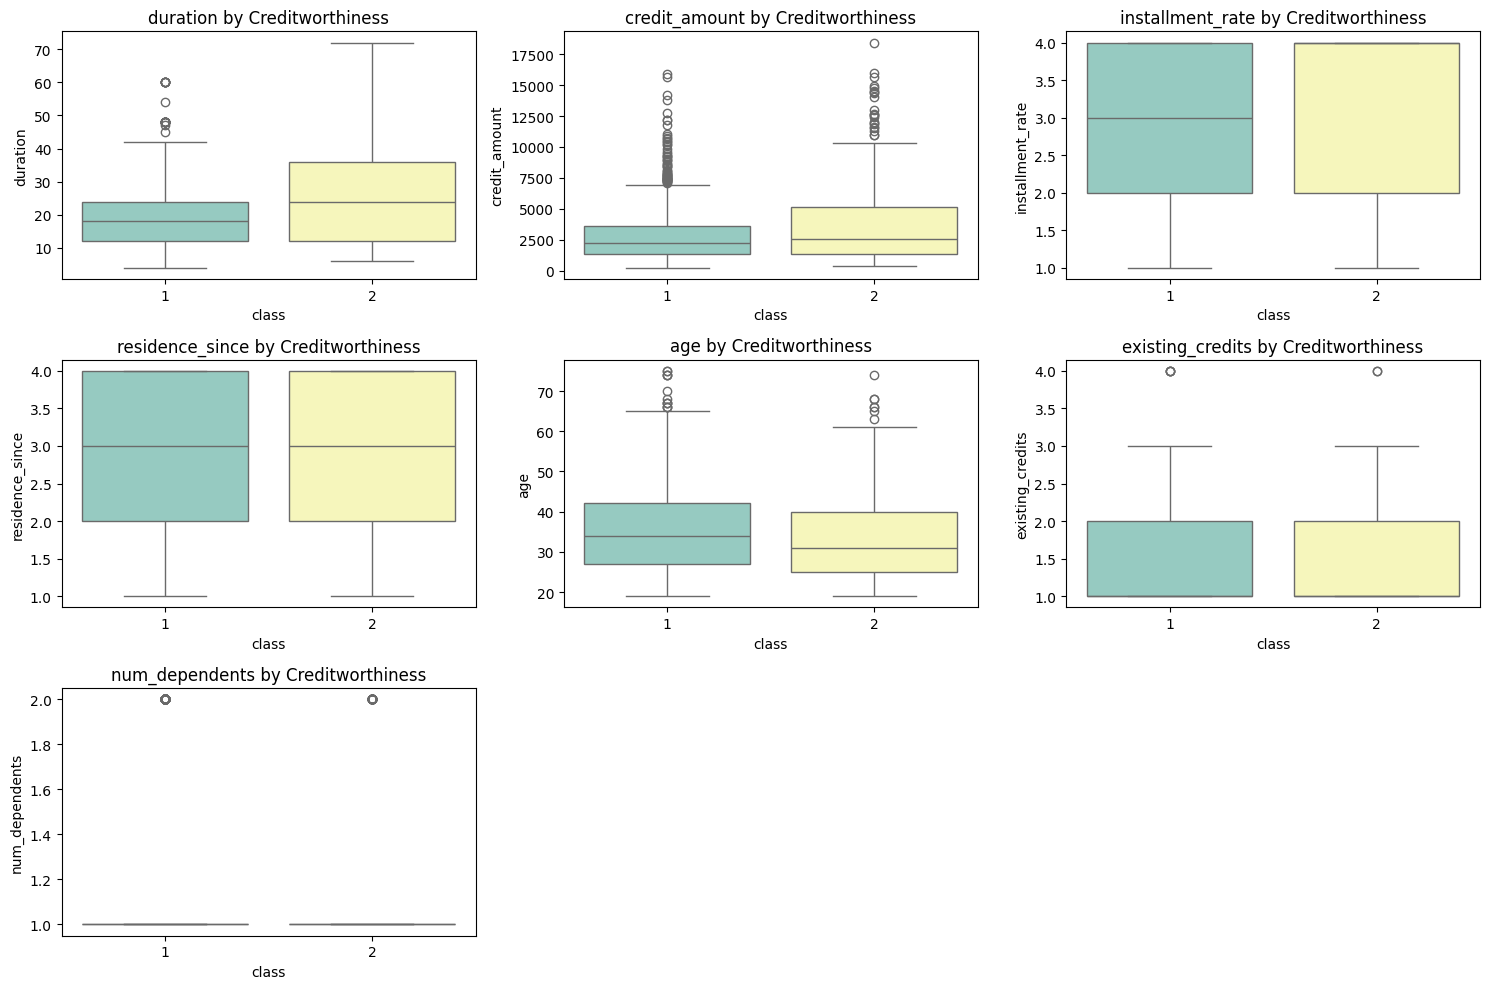

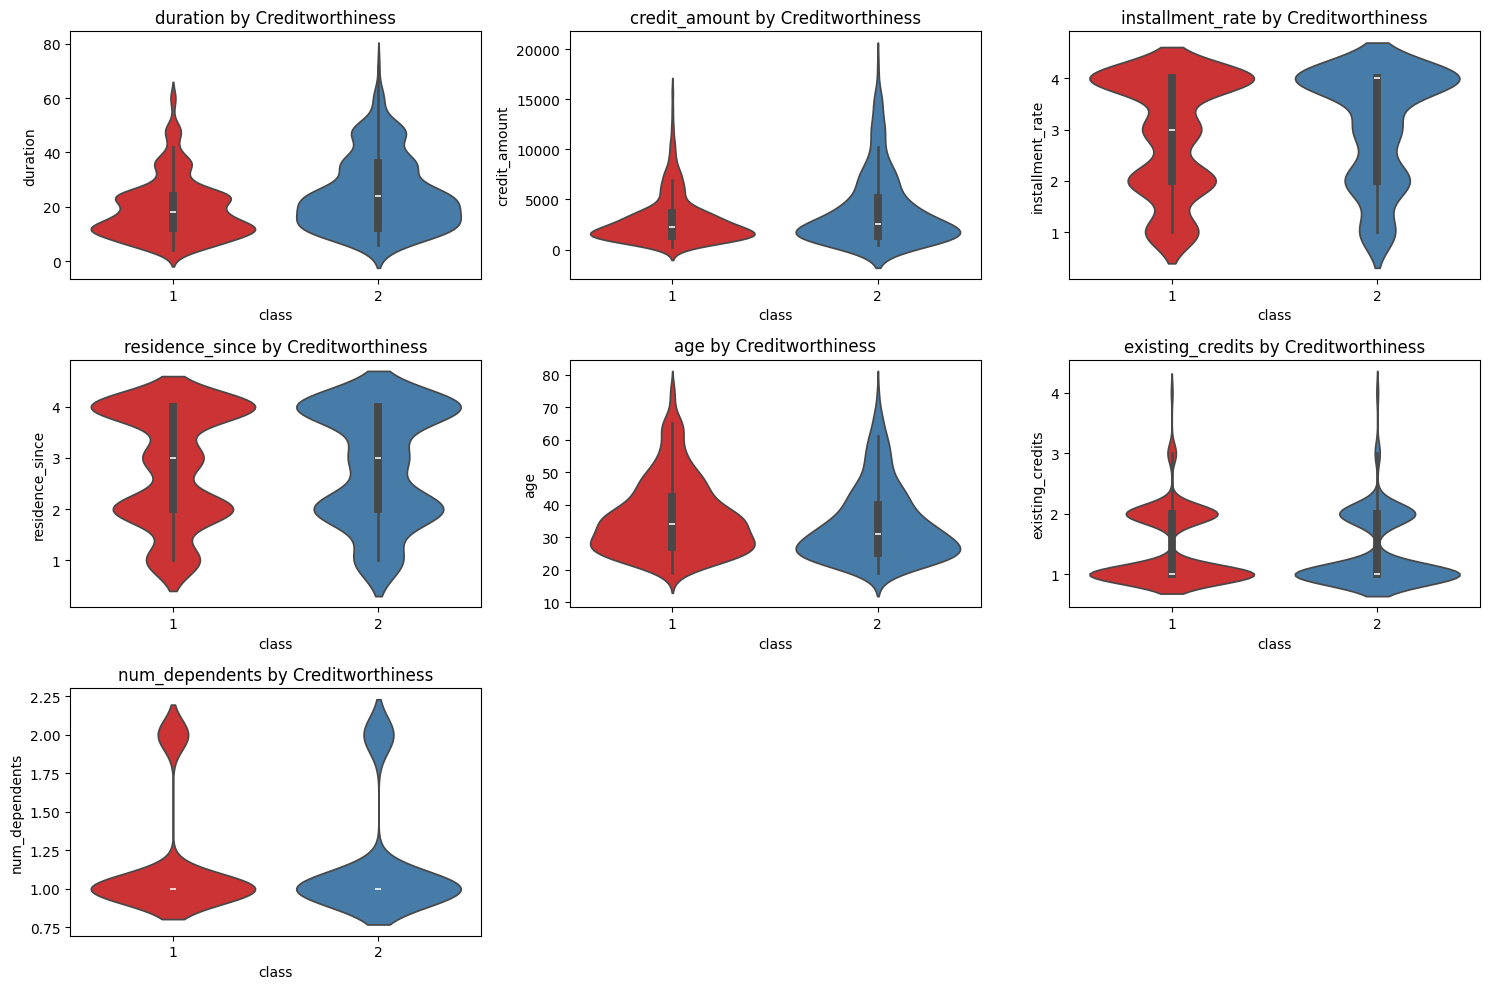

In [7]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='class', y=col, data=df, palette='Set3')
    plt.title(f'{col} by Creditworthiness')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x='class', y=col, data=df, palette='Set1')
    plt.title(f'{col} by Creditworthiness')
plt.tight_layout()
plt.show()

Bad credits (class 2) are associated with higher median `credit_amount` and longer `duration`, suggesting riskier loans. `age` shows younger individuals are slightly more likely to have bad credit. Violin plots reveal that the distribution of `credit_amount` for bad credits has a heavier tail, indicating larger loans.

## Bivariate Analysis - Categorical vs. Target
Use stacked bar plots to show proportions of good and bad credits for each category.

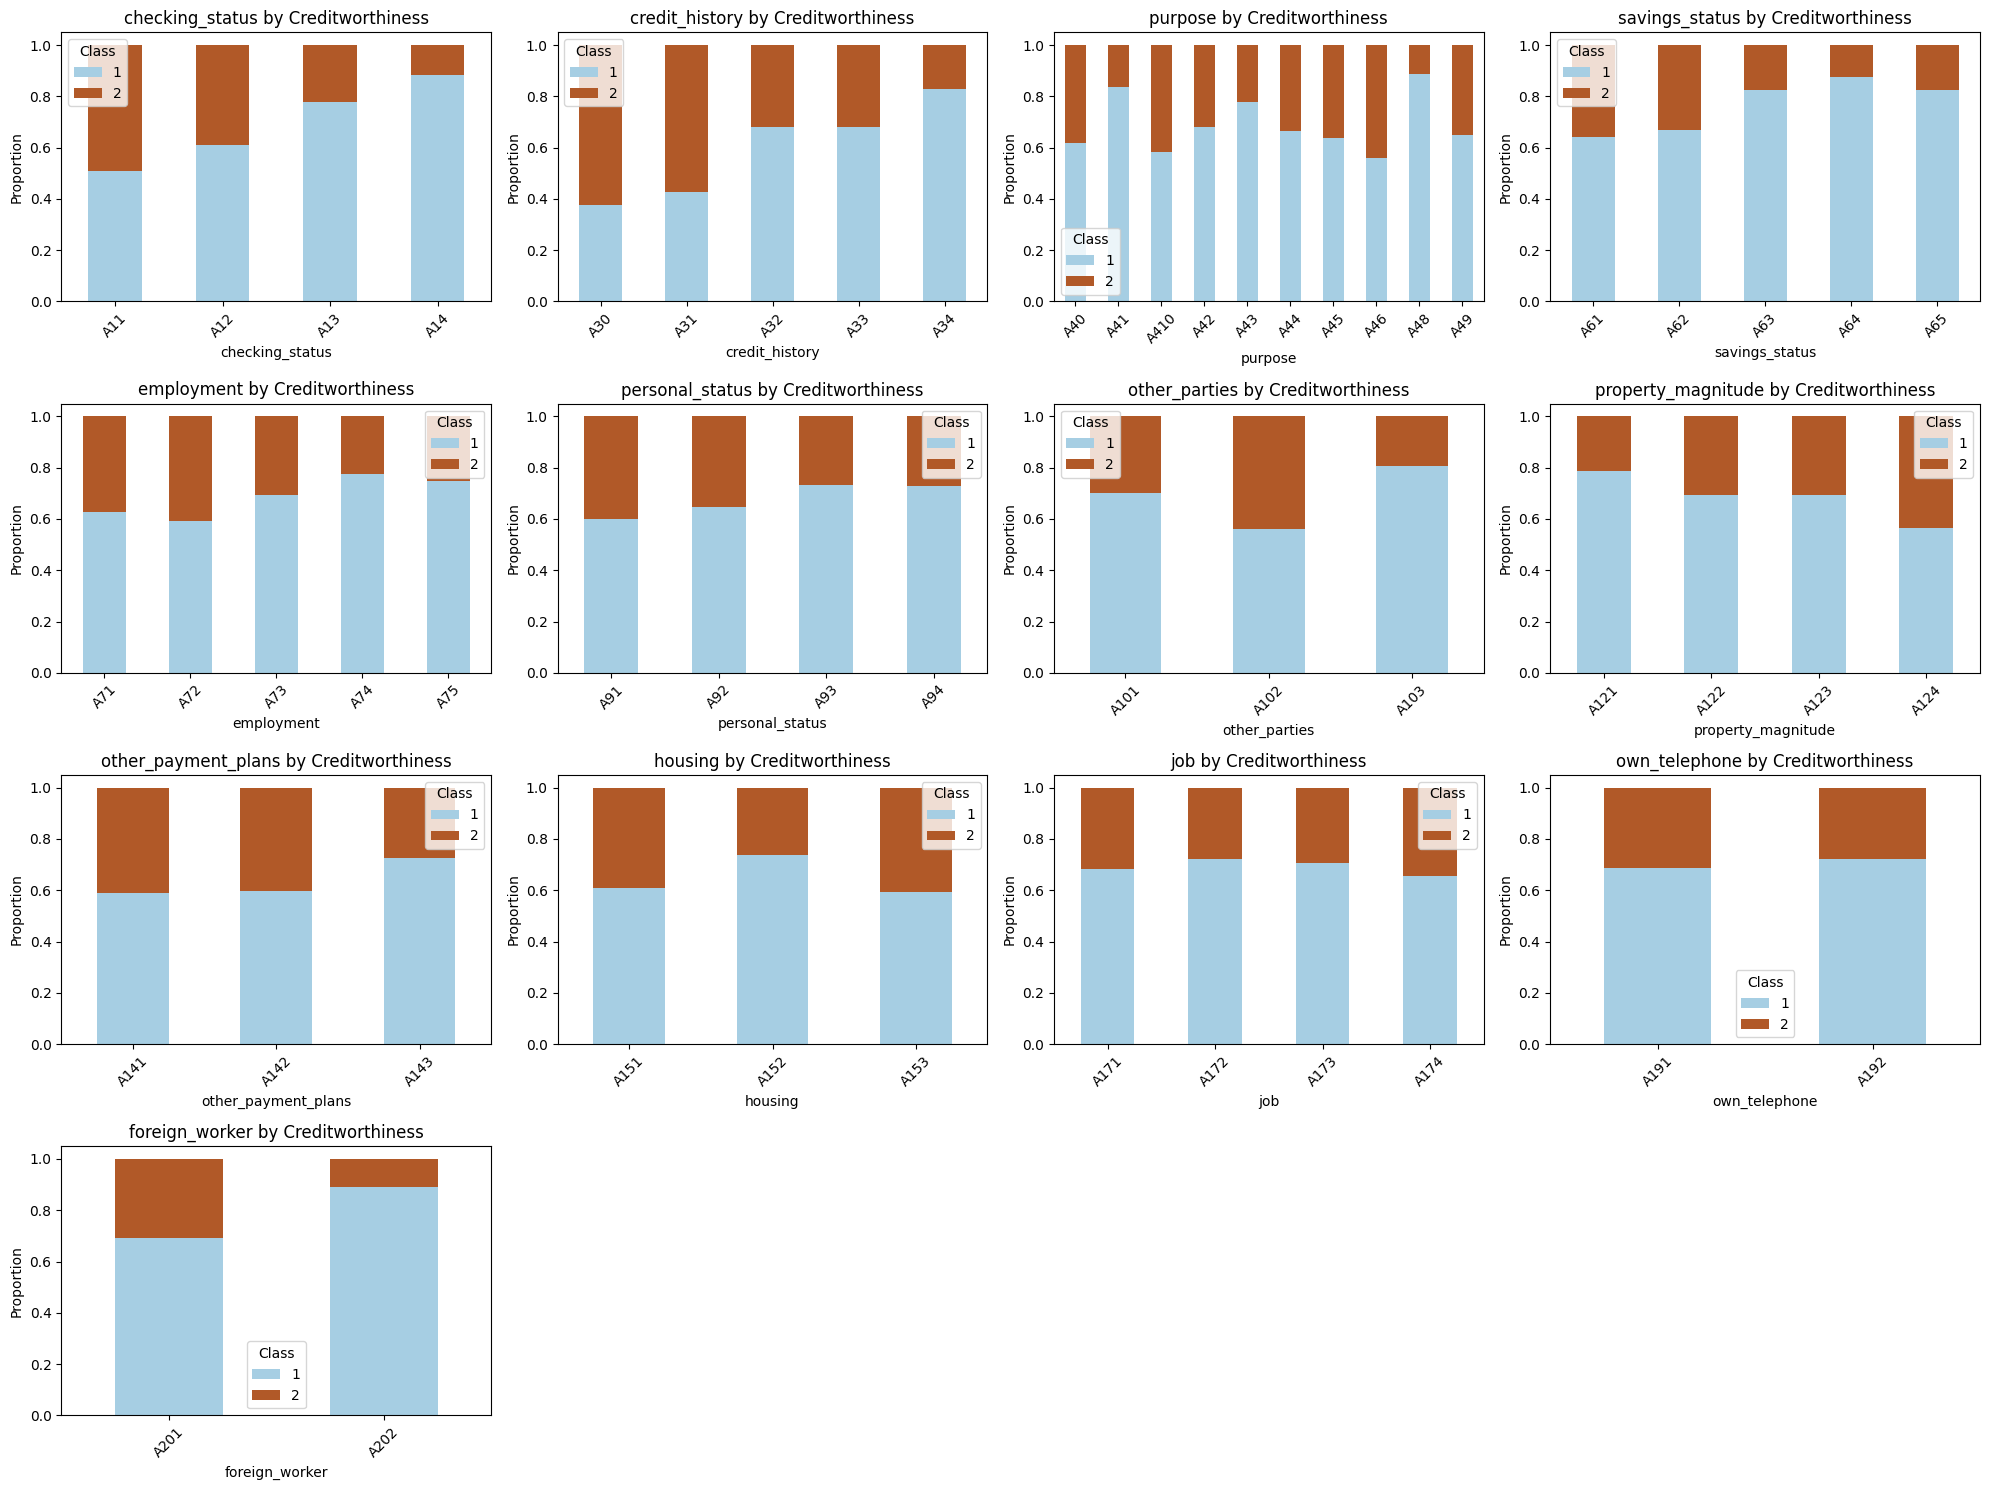

In [8]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 4, i)
    pd.crosstab(df[col], df['class'], normalize='index').plot(kind='bar', stacked=True, colormap='Paired', ax=plt.gca())
    plt.title(f'{col} by Creditworthiness')
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.legend(title='Class')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

For `checking_status`, 'A14' (no checking account) has a higher proportion of good credits (~80%), while 'A11' (<0 DM) has more bad credits (~50%). In `credit_history`, 'A34' (critical account) shows a higher proportion of good credits, possibly due to managed debts. `purpose` categories like 'A43' (radio/television) are associated with good credits.

## Correlation Analysis
Check correlations among numerical variables to identify potential multicollinearity.

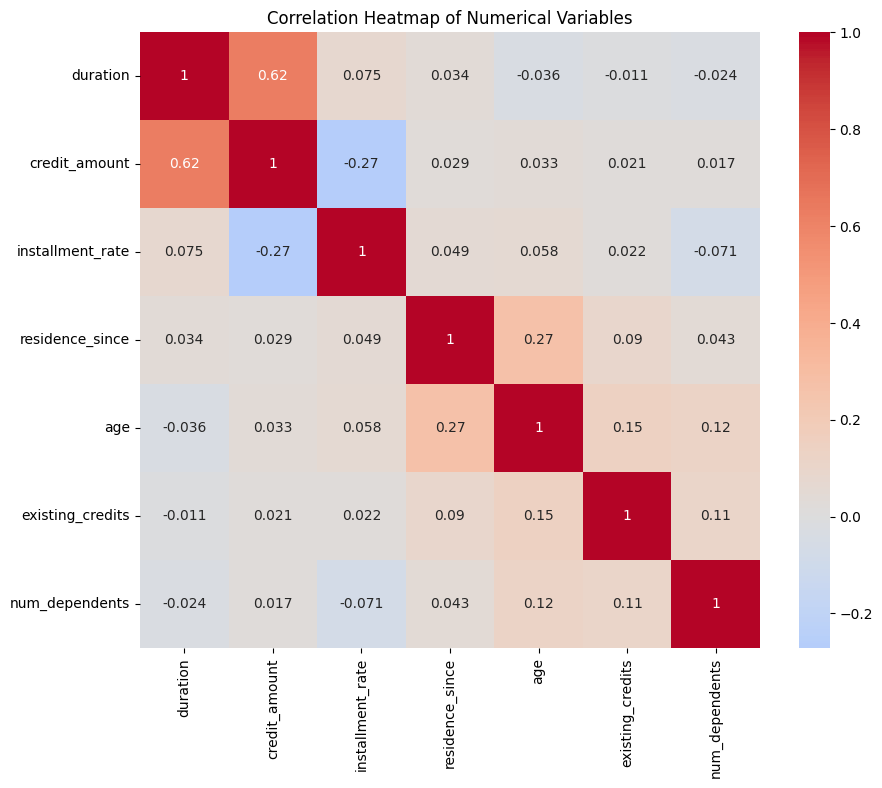

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

A moderate positive correlation (0.62) exists between `duration` and `credit_amount`, expected as larger loans often require longer repayment periods. Other correlations are weak (<0.3), suggesting no significant multicollinearity.

## Outlier Handling
Apply log transformation to `credit_amount` and `duration` to reduce skewness due to outliers.

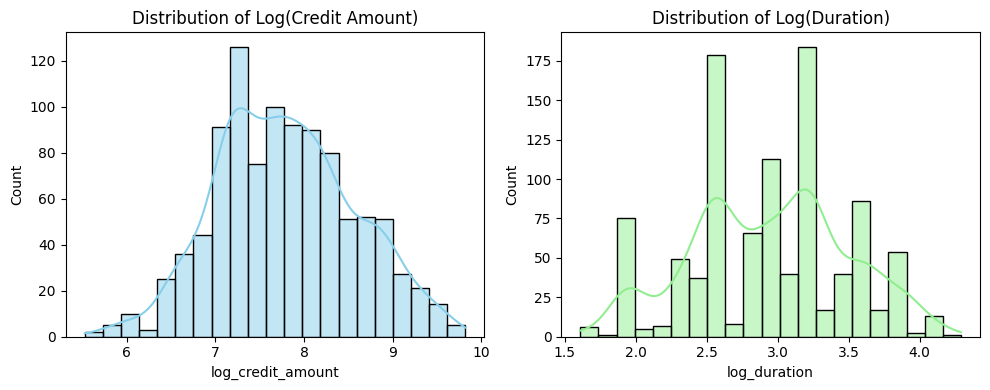

In [10]:
# Create log-transformed features
df['log_credit_amount'] = np.log1p(df['credit_amount'])
df['log_duration'] = np.log1p(df['duration'])

# Update numerical columns
numerical_cols = ['log_credit_amount', 'log_duration', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']

# Visualize transformed distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['log_credit_amount'], kde=True, color='skyblue')
plt.title('Distribution of Log(Credit Amount)')
plt.subplot(1, 2, 2)
sns.histplot(df['log_duration'], kde=True, color='lightgreen')
plt.title('Distribution of Log(Duration)')
plt.tight_layout()
plt.show()

**Insight**: Log transformation reduces the skewness of `credit_amount` and `duration`, making their distributions more normal-like, which can improve model performance despite random forests' robustness to outliers.

## Data Preprocessing
### Encoding Categorical Variables
Use ordinal encoding for ordinal variables (`savings_status`, `employment`, `job`) and one-hot encoding for nominal variables.

In [11]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define ordinal and nominal columns
ordinal_cols = ['savings_status', 'employment', 'job']
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]
numerical_cols = ['log_credit_amount', 'log_duration', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']

# Define categories for ordinal variables
ordinal_categories = [
    ['A65', 'A61', 'A62', 'A63', 'A64'],  # savings_status: no savings to >=1000 DM
    ['A71', 'A72', 'A73', 'A74', 'A75'],  # employment: unemployed to >=7 years
    ['A171', 'A172', 'A173', 'A174']      # job: low to high skill
]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

Ordinal encoding preserves the natural order of `savings_status`, `employment`, and `job`, while one-hot encoding handles nominal variables. The `handle_unknown='ignore'` parameter ensures robustness in the Streamlit app.

### Preparing Target Variable
Map the target variable to 0 (good) and 1 (bad).

In [12]:
df['class'] = df['class'].map({1:0, 2:1})

**Insight**: Mapping aligns with binary classification conventions, with bad credit as the positive class to emphasize its importance per the cost matrix.

### Splitting Data
Split the data into training and testing sets, using transformed features.

In [13]:
from sklearn.model_selection import train_test_split

# Update features to exclude original credit_amount and duration
X = df.drop(['class', 'credit_amount', 'duration'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The dataset is split into 80% training and 20% testing sets. Original `credit_amount` and `duration` are dropped in favor of their log-transformed versions.

## Model Training
Create a pipeline with preprocessing and a random forest classifier, incorporating class weights.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight={0:1, 1:5}, random_state=42))
])


The pipeline ensures consistent preprocessing and modeling. Class weights {0:1, 1:5} prioritize minimizing false negatives per the cost matrix.

### Hyperparameter Tuning
Use grid search to optimize hyperparameters.

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


Grid search optimizes the F1-score to balance precision and recall, addressing the class imbalance and cost matrix.

## Model Evaluation
Evaluate the model using classification metrics and total cost.

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate total cost
FP = cm[0][1]
FN = cm[1][0]
total_cost = FP * 1 + FN * 5
print(f"Total Cost (FP*1 + FN*5): {total_cost}")

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       141
           1       0.58      0.69      0.63        59

    accuracy                           0.76       200
   macro avg       0.72      0.74      0.73       200
weighted avg       0.78      0.76      0.77       200

Confusion Matrix:
[[111  30]
 [ 18  41]]
Total Cost (FP*1 + FN*5): 120


The classification report provides precision, recall, and F1-score. The total cost, calculated from the confusion matrix, reflects the model's ability to minimize costly false negatives.

## Feature Selection
Analyze feature importances and drop low-importance features (importance < 0.01).

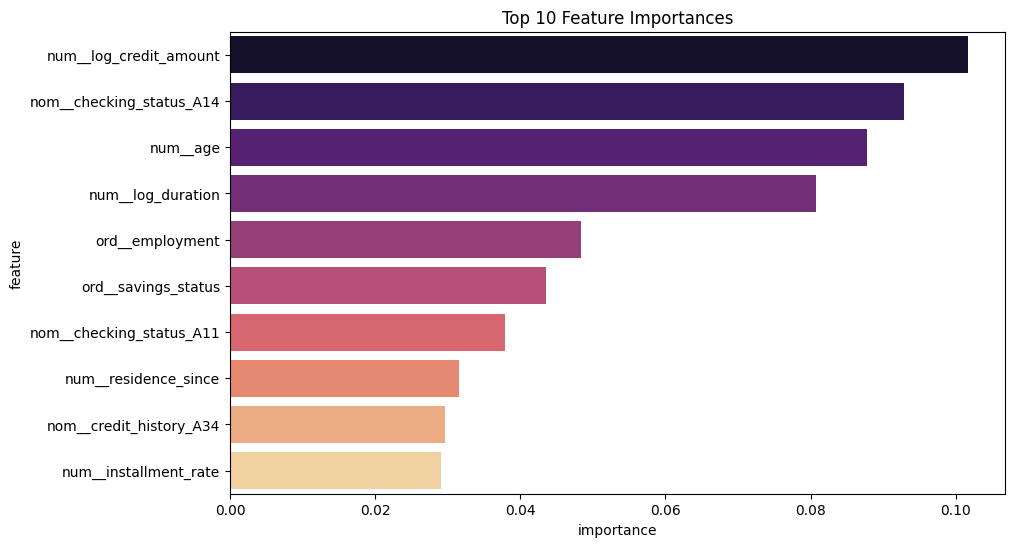

Features with importance < 0.01: ['nom__own_telephone_A191', 'nom__purpose_A42', 'nom__purpose_A49', 'nom__credit_history_A33', 'nom__purpose_A46', 'num__num_dependents', 'nom__property_magnitude_A122', 'nom__housing_A151', 'nom__property_magnitude_A123', 'nom__housing_A153', 'nom__credit_history_A30', 'nom__foreign_worker_A202', 'nom__foreign_worker_A201', 'nom__personal_status_A94', 'nom__credit_history_A31', 'nom__personal_status_A91', 'nom__other_payment_plans_A142', 'nom__purpose_A45', 'nom__other_parties_A102', 'nom__purpose_A44', 'nom__purpose_A410', 'nom__purpose_A48']


In [17]:
# Get feature names
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_

# Create DataFrame
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(10), palette='magma')
plt.title('Top 10 Feature Importances')
plt.show()

# Identify features to drop
low_importance_features = feat_imp_df[feat_imp_df['importance'] < 0.01]['feature'].tolist()
print("Features with importance < 0.01:", low_importance_features)

**Insight**: Features like `checking_status`, `log_credit_amount`, and `log_duration` are typically among the most important. Features with importance < 0.01 may be dropped to simplify the model, but we retain all for now to maintain information.

## Export Model
Save the trained model and preprocessor.

In [18]:
import joblib
joblib.dump(best_model, 'model/credit_model.pkl')

['model/credit_model.pkl']